<a href="https://colab.research.google.com/github/bubabi/covid-19-forecasting/blob/colab_dev/ARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/dataset/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
countries_useful_features.csv  covid19-global-forecasting-week-4
covid_19_clean_complete.csv    covid19-global-forecasting-week-5


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import datetime
import itertools
import matplotlib.dates as mdates
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Understanding

## Gathering data

We obtained the data provided by Kaggle and some university sources in csv format. These included case, death and recovery statistics in the form of time series. We also found a data set about the countries, lockdown type, average age and total population.

[**COVID-19 Dataset**
(Confirmed, Death and Recovered cases every day across the globe)](https://www.kaggle.com/imdevskp/corona-virus-report)

[COVID-19 **Useful features by country**](https://www.kaggle.com/c/covid19-global-forecasting-week-5/discussion/148263)

In [0]:
# train = pd.read_csv("/content/drive/My Drive/dataset/data/covid19-global-forecasting-week-4/train.csv")
# test = pd.read_csv("/content/drive/My Drive/dataset/data/covid19-global-forecasting-week-4/test.csv")
clean_complete_df = pd.read_csv('/content/drive/My Drive/dataset/data/covid_19_clean_complete.csv', parse_dates=['Date'])
useful_features = pd.read_csv("/content/drive/My Drive/dataset/data/countries_useful_features.csv")

## Describing data

Basically, we have determined the mandatory parts that should be included in our data as Date (datetime), Number of confirmed cases (int64), Number of deaths (int64) and Number of recovered (int64), Country (object).

In [4]:
display(clean_complete_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30740 entries, 0 to 30739
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  9280 non-null   object        
 1   Country/Region  30740 non-null  object        
 2   Lat             30740 non-null  float64       
 3   Long            30740 non-null  float64       
 4   Date            30740 non-null  datetime64[ns]
 5   Confirmed       30740 non-null  int64         
 6   Deaths          30740 non-null  int64         
 7   Recovered       30740 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.9+ MB


None

## Exploring data

The dataset contains cumulative statistics for all countries of every day. In order to examine the **daily case statistics**, we may need to take the difference of the lines and create a new dataframe in the future. We can create a function to do this for every country.

In [5]:
clean_complete_df.sort_values(by='Date').describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,30740.000000,30740.000000,3.074000e+04,30740.000000,30740.000000
mean,21.181891,22.881195,4.464725e+03,297.383604,1311.136207
std,24.904277,70.245571,4.057051e+04,2811.876832,9658.594359
min,-51.796300,-135.000000,0.000000e+00,0.000000,0.000000
25%,6.877000,-15.310100,0.000000e+00,0.000000,0.000000
50%,23.634500,21.005900,1.800000e+01,0.000000,1.000000
75%,41.153300,78.000000,3.930000e+02,5.000000,90.000000
max,71.706900,178.065000,1.467820e+06,88754.000000,268376.000000


In [6]:
# display(train.head())
display(clean_complete_df.head())
display(useful_features.head())

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


,Country_Region,Population_Size,Tourism,Date_FirstFatality,Date_FirstConfirmedCase,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Country_Code
0,Afghanistan,37172386,14000,2020-03-23,2020-02-25,33.939110,67.709953,17.3,2020-03-24,Full,AFG
1,Albania,2866376,5340000,2020-03-12,2020-03-10,41.153332,20.168331,36.2,2020-03-08,Full,ALB
2,Algeria,42228429,2657000,2020-03-13,2020-02-26,28.033886,1.659626,27.5,2020-03-24,Full,DZA
3,Andorra,77006,3042000,2020-03-23,2020-03-03,42.546245,1.601554,37.0,2020-03-16,Full,AND
4,Angola,30809762,218000,2020-03-30,2020-03-21,-11.202692,17.873887,16.4,NaN,NaN,AGO


The dataset contains data collected from January 22, 2020, the first date when the data began to be collected, until May 16, 2020.

In [7]:
print("The lowest date in the data set is", clean_complete_df['Date'].min() ,"and the highest", clean_complete_df['Date'].max())

The lowest date in the data set is 2020-01-22 00:00:00 and the highest 2020-05-16 00:00:00


## Verifying data quality

The data set we have has all the content about the outbreak forecast and contains accurate statistics. No other data source is required.

# Data Preparation

To determine the number of **active** patients, we subtracted the number of patients who died and recovered from the total number of cases. Also, since we will not use the Province/State column, we removed this column from the data.

In [8]:
clean_complete_df['Active'] = clean_complete_df['Confirmed'] - clean_complete_df['Deaths'] - clean_complete_df['Recovered']
df = clean_complete_df.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
display(df.head())

,Date,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0,0
1,2020-01-22,Albania,0,0,0,0
2,2020-01-22,Algeria,0,0,0,0
3,2020-01-22,Andorra,0,0,0,0
4,2020-01-22,Angola,0,0,0,0


In [9]:
# date:string -> date:datatime
# train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
# train[train.select_dtypes(['float64']).columns] = train.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))
# test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')
# test[test.select_dtypes(['float64']).columns] = test.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))
df.dtypes

Date              datetime64[ns]
Country/Region            object
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
dtype: object

In [0]:
# train.fillna("None", inplace=True)
# test.fillna("None", inplace=True)
useful_features.fillna("None", inplace=True)

## Constructing data

We have grouped the Confirmed cases and death columns by Date with the groupby function to reach the worldwide **cumulative number of cases**. We created the table where we obtained **daily statistics** according to time by taking the difference with the diff function to the cumulative table.

In [11]:
cumulative_df = df.groupby('Date', as_index=False)['Confirmed','Deaths'].sum().sort_values(by='Date')

daily_df = cumulative_df.copy(deep=True)
daily_df[daily_df.columns.difference(['Date'])] = daily_df[daily_df.columns.difference(['Date'])].diff(axis=0).fillna(0)
daily_df[daily_df.select_dtypes(['float64']).columns] = daily_df.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))

display(daily_df.tail())
display(cumulative_df.tail())

,Date,Confirmed,Deaths
111,2020-05-12,84245,5612
112,2020-05-13,85271,5255
113,2020-05-14,95145,5221
114,2020-05-15,100184,5248
115,2020-05-16,91721,4115


,Date,Confirmed,Deaths
111,2020-05-12,4261741,291942
112,2020-05-13,4347012,297197
113,2020-05-14,4442157,302418
114,2020-05-15,4542341,307666
115,2020-05-16,4634062,311781


The number of reported cases per day does not show a steep climb as early as. We can say that the epidemic still continues to spread rapidly. The total number of cases has exceeded 4 million.

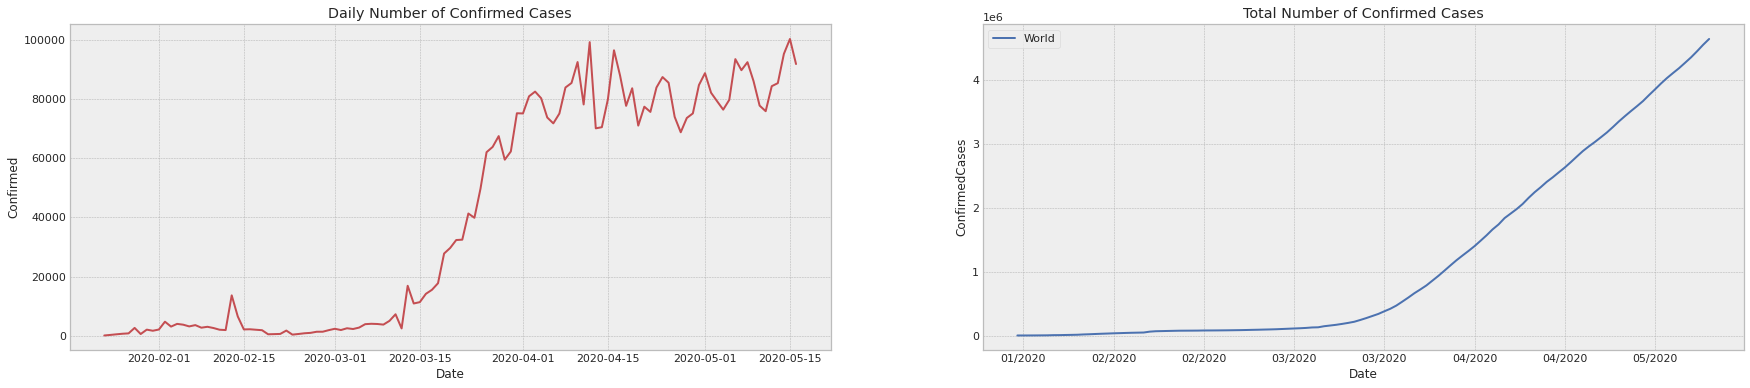

<Figure size 684x432 with 0 Axes>

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 6))

ax1.plot(cumulative_df.loc[1:, 'Date'], daily_df.loc[1:, 'Confirmed'], label="World", color="r")
ax1.set(xlabel="Date",
       ylabel="Confirmed",
       title="Daily Number of Confirmed Cases")

ax2.plot(cumulative_df['Date'].values, cumulative_df['Confirmed'], label="World", color="b")
ax2.set(xlabel="Date",
       ylabel="ConfirmedCases",
       title="Total Number of Confirmed Cases")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

When we look at the daily data, death cases started to decrease. This indicates that the fight against the epidemic is getting better. The new treatment methods applied seem successful.

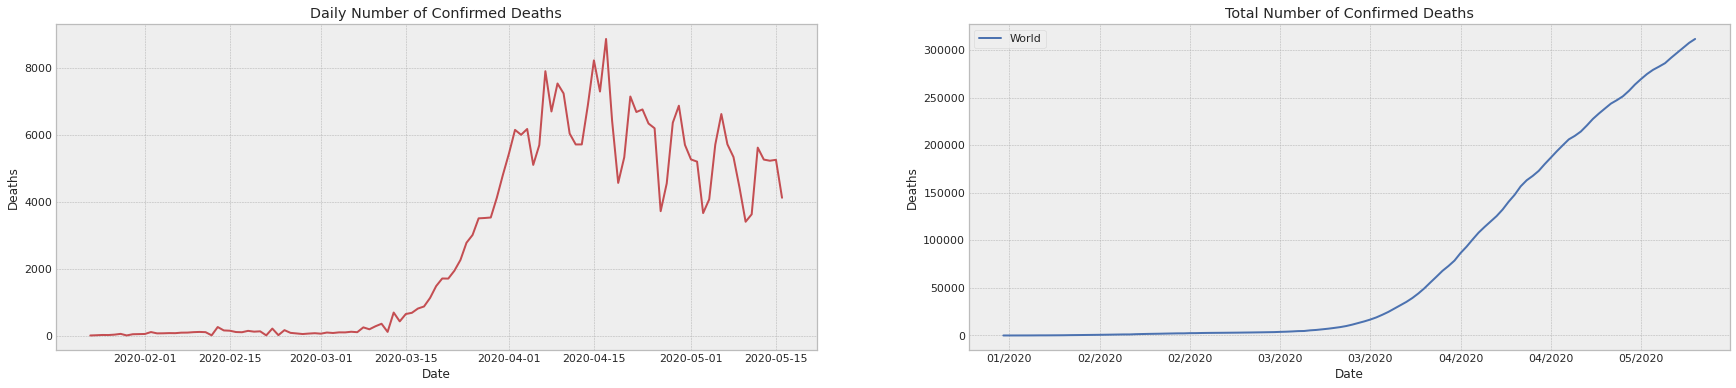

<Figure size 684x432 with 0 Axes>

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 6))

ax1.plot(cumulative_df.loc[1:, 'Date'], daily_df.loc[1:, 'Deaths'], label="World", color="r")
ax1.set(xlabel="Date",
       ylabel="Deaths",
       title="Daily Number of Confirmed Deaths")

ax2.plot(cumulative_df['Date'].values, cumulative_df['Deaths'], label="World", color="b")
ax2.set(xlabel="Date",
       ylabel="Deaths",
       title="Total Number of Confirmed Deaths")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()


We wrote a function like the one below for future use. This function returns daily or cumulative statistics according to the desired country name. We decide whether it is daily or not with the "daily" parameter.

In [0]:
def get_df_by_country(df_country, country, daily=True):
    # return country_by_daily.loc[(country_by_daily['Country/Region'] == country) & (country_by_daily['Confirmed'] > 0) & (country_by_daily['Date'] >= '2020-03-01')]
    tmp = df_country.loc[:, ['Date', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']].loc[(df_country['Country/Region'] == country)]
    tmp.index = np.arange(0, len(tmp))
    if daily:
        tmp[tmp.columns.difference(['Date', 'Country/Region'])] = tmp[tmp.columns.difference(['Date', 'Country/Region'])].diff(axis=0).fillna(0)
        tmp[tmp.select_dtypes(['float64']).columns] = tmp.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))
        return tmp 
    else:
        return tmp

Total confirmed cases: how rapidly have they increased compared to other countries?

We have grouped the countries with the highest number of cases currently by Country / Region column. We observe that the number of positive cases is rapidly increasing in** US and Russia** compared to other countries. We can say that Russia is successful in treatment compared to the number of cases. On the other hand, we see that** Italy reported a high number of fatalities** in treatment failures.

In [15]:
top10_countries = df[df['Date'] == df['Date'].max()]
top10_countries = top10_countries.groupby('Country/Region', as_index=False)['Confirmed','Deaths'].sum()
top10_countries = top10_countries.nlargest(10, 'Confirmed')
top10_countries

,Country/Region,Confirmed,Deaths
174,US,1467820,88754
139,Russia,272043,2537
178,United Kingdom,241461,34546
23,Brazil,233511,15662
158,Spain,230698,27563
85,Italy,224760,31763
62,France,179630,27532
66,Germany,175752,7938
173,Turkey,148067,4096
81,Iran,118392,6937


In the graph below, we see how high the number of confirmed cases is due to the loose policy of the US at the beginning of the pandemic.

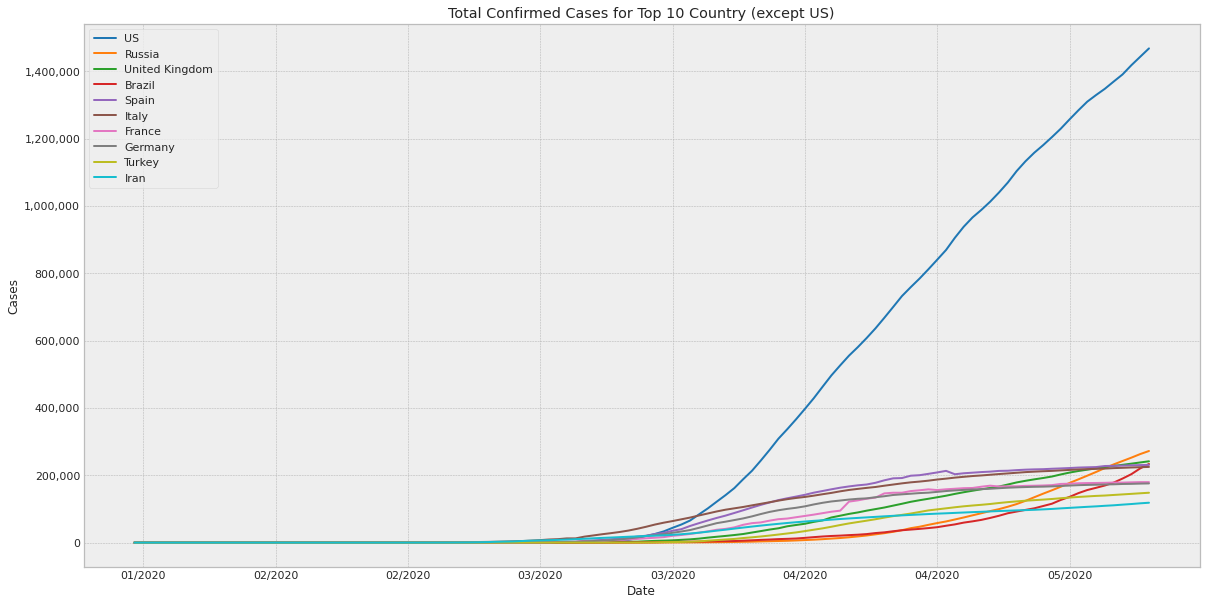

<Figure size 684x432 with 0 Axes>

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i, country_name in enumerate(top10_countries['Country/Region'].values):

    tmp_df = get_df_by_country(df, country_name, daily=False)
    ylabels = [format(label, ',.0f') for label in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    ax.plot(tmp_df['Date'].values, tmp_df['Confirmed'], label=country_name, color=colors[i])

ax.set(xlabel="Date",
       ylabel="Cases",
       title="Total Confirmed Cases for Top 10 Country (except US)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

# SIR MODEL

https://www.kaggle.com/khanalkiran/covid19-ca-sir-model

https://www.kaggle.com/carloslira/covid19-mexico-sir-map-with-geopandas

https://github.com/RemiTheWarrior/epidemic-simulator/blob/master/epidemic.py

https://www.kaggle.com/dgrechka/sir-model-fit-for-italy

https://www.kaggle.com/abhijithchandradas/sir-model-don-t-understand-calculus-don-t-worry

![alt text](https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png)


In [0]:
from scipy.integrate import odeint
from scipy import integrate, optimize
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [0]:
def SIR_model_test(y, t, N, beta, gamma):
    S, I, R = y
    dSt = (-beta * S * I / N)
    dIt = (beta * S * I / N) - (gamma * I)
    dRt = gamma * I
    return dSt, dIt, dRt

In [0]:
N = 1
beta = 0.35
gamma = 0.1
S0, I0, R0 = (0.9, 0.1, 0.0)

In [0]:
t = np.linspace(0, 100, 1000)
y0 = S0, I0, R0 # Initial conditions vector

result = odeint(SIR_model_test,[S0, I0, R0], t, args=(N, beta,gamma))
S, I, R = result.T

In [0]:
def plotsir(t, S, I, R):
    f, ax = plt.subplots(1,1,figsize=(12,6))
    ax.plot(t, S, linewidth=2, label='Susceptible')
    ax.plot(t, I, linewidth=2, label='Infected')
    ax.plot(t, R, linewidth=2, label='Recovered')
    ax.set_xlabel('Time (days)')
    ax.legend()
    plt.show();

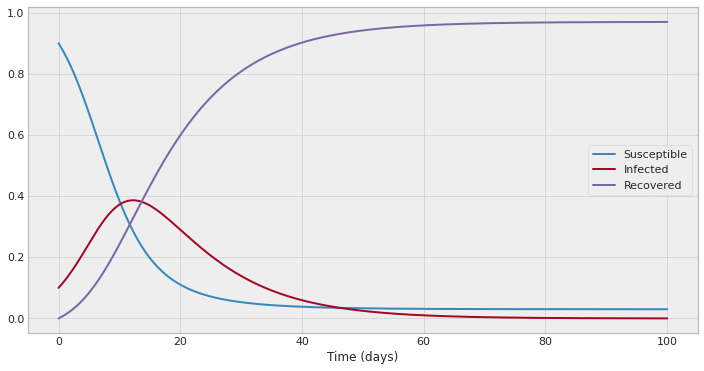

In [22]:
plotsir(t, S, I, R)

In [0]:
country_name = 'Turkey'
turkey_df = get_df_by_country(df, country_name, daily=False)

# using LabelEncoder to transform Date column
turkey_df['DayNo'] = preprocessing.LabelEncoder().fit_transform(turkey_df.Date)

turkey_population = useful_features[useful_features['Country_Region'] == country_name].Population_Size.values[0]
turkey_df['R'] = turkey_df['Deaths'] + turkey_df['Recovered']
turkey_df['I'] = turkey_df['Confirmed'] - turkey_df['R']
turkey_df['S'] = turkey_population-turkey_df['Confirmed'] - turkey_df['I'] - turkey_df['R']

In [24]:
turkey_df.tail()

,Date,Country/Region,Confirmed,Deaths,Recovered,DayNo,R,I,S
111,2020-05-12,Turkey,141475,3894,98889,111,102783,38692,82036774
112,2020-05-13,Turkey,143114,3952,101715,112,105667,37447,82033496
113,2020-05-14,Turkey,144749,4007,104030,113,108037,36712,82030226
114,2020-05-15,Turkey,146457,4055,106133,114,110188,36269,82026810
115,2020-05-16,Turkey,148067,4096,108137,115,112233,35834,82023590


In [0]:
def SIR_model_turkey(y, t, beta, gamma):
    S, I, R = y
    N = turkey_population
    dSt = (-beta * S * I / N)
    dIt = (beta * S * I / N) - (gamma * I)
    dRt = gamma * I
    return dSt, dIt, dRt

def fit_ode(x, beta, gamma):
    return integrate.odeint(SIR_model_turkey, (S0, I0, R0), x, args=(beta, gamma))[:,1]

Beta= 3.03188819023688 , Gamma= 2.895438922555611
MSE: 19404287.854491983


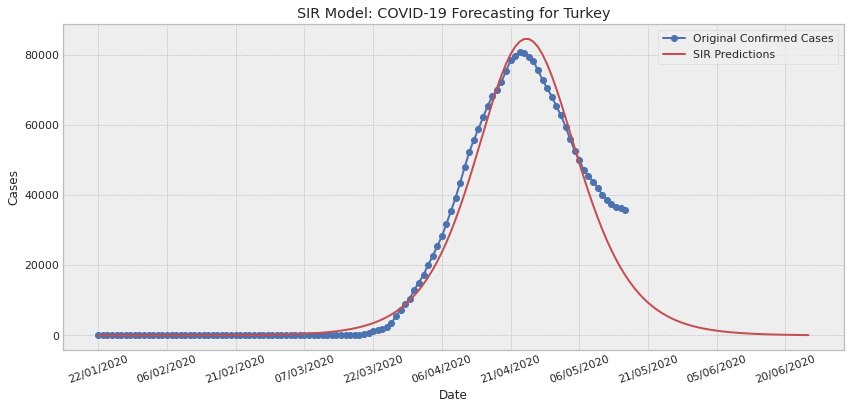

<Figure size 684x432 with 0 Axes>

In [26]:
N, I0 = turkey_population, 1
S0, R0 = turkey_population-I0, 0

x_values = turkey_df.DayNo
x_values = np.array(x_values, dtype=float)

y_values = np.array(turkey_df['I'], dtype=float)
y_values = np.array(y_values, dtype=float)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# Use non-linear least squares to fit a function, f, to data.
popt, pcov = optimize.curve_fit(fit_ode, x_values, y_values)
beta = popt[0]
gamma = popt[1]
print("Beta=", beta, ", Gamma=", gamma)

time = np.arange(0, 156, 1)
fitted = integrate.odeint(SIR_model_turkey, (S0, I0, R0), time, args=(beta, gamma))[:,1]

print("MSE:", mean_squared_error(y_values, fitted[:len(y_values)]))
x_dates = pd.date_range(start='2020-01-22', end='2020-05-16')
dates = pd.date_range(start='2020-01-22', end='2020-06-25')
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(x_dates, y_values, label='Original Confirmed Cases', color='b', marker='o')
ax.plot(dates, fitted, label='SIR Predictions', color='r')

ax.set(xlabel="Date",
       ylabel="Cases",
       title="SIR Model: COVID-19 Forecasting for Turkey")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.xticks(rotation=20)
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

In [0]:
def SIR_model_by_country(_df, country_name):

    def SIR_model(y, t, beta, gamma):
        S, I, R = y
        N = country_population
        dSt = (-beta * S * I / N)
        dIt = (beta * S * I / N) - (gamma * I)
        dRt = gamma * I
        return dSt, dIt, dRt

    def fit_ode(x, beta, gamma):
        return integrate.odeint(SIR_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

    sir_df = get_df_by_country(_df, country_name, daily=False)

    # using LabelEncoder to transform Date column
    sir_df['DayNo'] = preprocessing.LabelEncoder().fit_transform(sir_df.Date)

    country_population = useful_features[useful_features['Country_Region'] == country_name].Population_Size.values[0]
    sir_df['R'] = sir_df['Deaths'] + sir_df['Recovered']
    sir_df['I'] = sir_df['Confirmed'] - sir_df['R']
    sir_df['S'] = country_population-sir_df['Confirmed'] - sir_df['I'] - sir_df['R']

    N, I0 = country_population, 1
    S0, R0 = country_population-I0, 0

    x_values = sir_df.DayNo
    x_values = np.array(x_values, dtype=float)

    y_values = np.array(sir_df['I'], dtype=float)
    y_values = np.array(y_values, dtype=float)

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    # Use non-linear least squares to fit a function, f, to data.
    popt, pcov = optimize.curve_fit(fit_ode, x_values, y_values)
    beta = popt[0]
    gamma = popt[1]
    print("Beta=", beta, ", Gamma=", gamma)
    time = np.arange(0, 156, 1)
    x_dates = pd.date_range(start='2020-01-22', end='2020-05-16')
    dates = pd.date_range(start='2020-01-22', end='2020-06-25')

    fitted = integrate.odeint(SIR_model, (S0, I0, R0), time, args=(beta, gamma))[:,1]
    print("MSE:", mean_squared_error(y_values, fitted[:len(y_values)]))
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(x_dates, y_values, label='Original Confirmed Cases', color='b', marker='o')
    ax.plot(dates, fitted, label='SIR Predictions', color='r')

    ax.set(xlabel="Date",
        ylabel="Cases",
        title="SIR Model: COVID-19 Forecasting for " + country_name)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=20)
    plt.legend()
    plt.show()
    plt.gcf().autofmt_xdate()

Beta= 2.148553769312847 , Gamma= 2.0030803950033915
MSE: 762470203.6623366


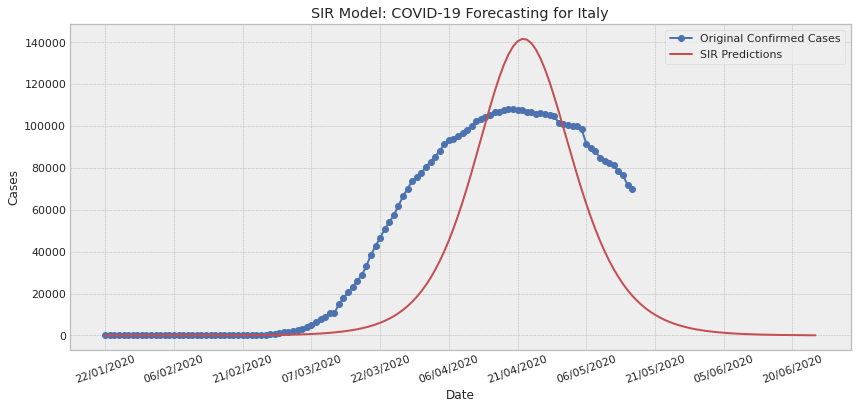

<Figure size 684x432 with 0 Axes>

In [28]:
SIR_model_by_country(df, 'Italy')

Beta= 2.0786972129358974 , Gamma= 1.9311973499149362
MSE: 411110563.2946087


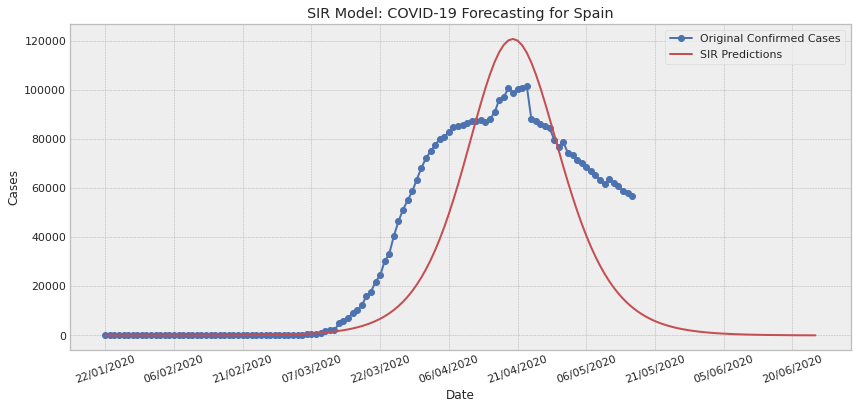

<Figure size 684x432 with 0 Axes>

In [29]:
SIR_model_by_country(df, 'Spain')

Beta= 5.361312704927809 , Gamma= 5.207567676425497
MSE: 35847195.100449376


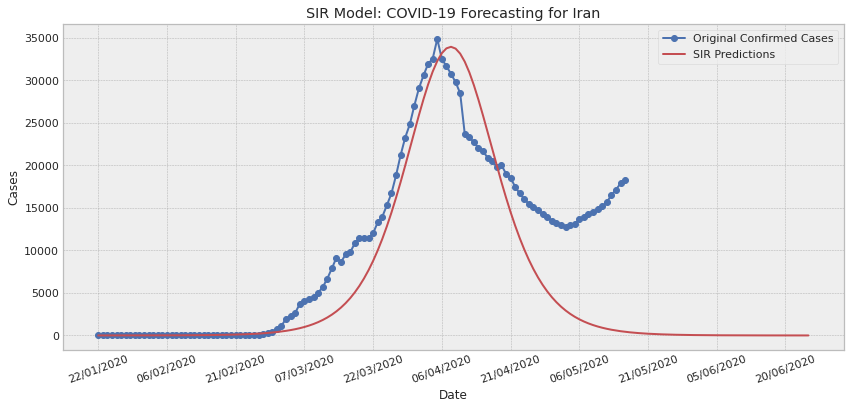

<Figure size 684x432 with 0 Axes>

In [30]:
SIR_model_by_country(df, 'Iran')

# Modeling & Evaluation

### SIR 


### ARIMA

We will model our time series data using **ARIMA** (autoregressive integration moving average) and make predictions about the future. Its general use is ARIMA (p, d, q). p autoregressive ar(p) is used for the part, and d indicates how many times the data series will be reduced. In other words, it means the new series obtained by removing each data from the previous data. d is generally used to eliminate the trend in the data and to reach stationarity.

### SARIMAX

DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


## Building Model
https://dataplatform.cloud.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c

https://machinelearningmastery.com/time-series-data-stationary-python/

Before we buildin a model, we must ensure that the time series is stationary. First of all, let's explain what it means to be stationary of a time series data with the example below. 

![stationary](http://www.seanabu.com/img/Mean_nonstationary.png)

The value shown in the plot is the mean of the time series data. As on the right, if this value **increases over time**, our data is not stationary. In other words, our data can be expressed **as a function of time**. However, in the graph on the left, this value **does not increase with time**, so it seems stationary.


# Decomposing the time series data for Turkey

In [31]:
df_turkey_daily = get_df_by_country(df, 'Turkey', daily=True)
df_turkey_cumulative = get_df_by_country(df, 'Turkey', daily=False)

display(df_turkey_daily.tail())
display(df_turkey_cumulative.tail())

,Date,Country/Region,Confirmed,Deaths,Recovered
111,2020-05-12,Turkey,1704,53,3109
112,2020-05-13,Turkey,1639,58,2826
113,2020-05-14,Turkey,1635,55,2315
114,2020-05-15,Turkey,1708,48,2103
115,2020-05-16,Turkey,1610,41,2004


,Date,Country/Region,Confirmed,Deaths,Recovered
111,2020-05-12,Turkey,141475,3894,98889
112,2020-05-13,Turkey,143114,3952,101715
113,2020-05-14,Turkey,144749,4007,104030
114,2020-05-15,Turkey,146457,4055,106133
115,2020-05-16,Turkey,148067,4096,108137


**Additive Model**

An additive model suggests that the components are added together as follows:

**y(t)** = *Level* + *Trend* + *Seasonality* + *Noise*

-> Residual yorumu

-> Seasonal yorumu

(116, 5)

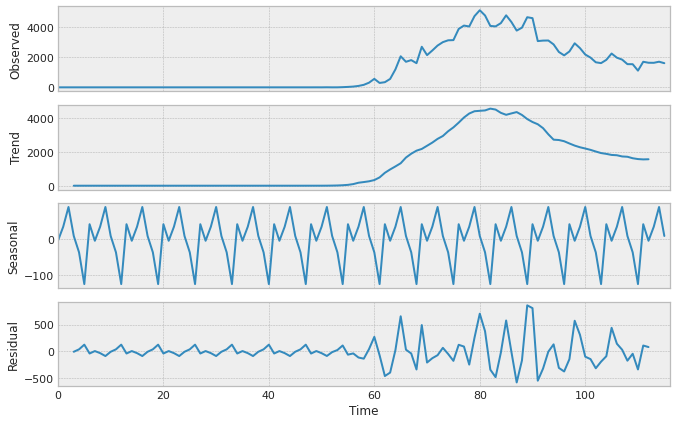

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
display(df_turkey_daily.shape)
fig=sm.tsa.seasonal_decompose(df_turkey_daily.Confirmed.values, model='additive', freq=7).plot()


When using a statistical model, we assume that the data are independent from each other. However, in this case, we know that each data point is dependent on a certain time. To use such a model, statistical properties must be constant over time. So the data must be stationary.

There are two methods to decide whether the data is stationary. One of them is to plot the mean and std. of the data depending on time. If these values remain constant over time, it is stationary. However, making visual inferences is not always accurate and feasible.

The other methos is the Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The idea behind a unit root test is that it determines how strongly a time series is defined by a trend.

*   **Rolling Statistics:** Plot statistical properties then make visual inferences. The time series is stationary if they remain constant with time.
*   **Augmented Dickey-Fuller Test:** In order to call a data stationary, the test statistic value must be smaller than or closer the critical values and the p-value must be less than 0.05.

In [0]:
from statsmodels.tsa.stattools import adfuller

def is_stationary(df_ts):
    # starting from the first day, we calculate the mean 
    # and standard deviation in a 7-day window width called rolling mean/std.
    rolling_mean = df_ts.rolling(window=7).mean()
    rolling_std = df_ts.rolling(window=7).std()
    
    # Rolling Statistics:
    plt.plot(df_ts, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
    # Augmented Dickey-Fuller Test:
    result = adfuller(df_ts)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


For the original data, we run the tests in the above function. We see that statistical properties increase with respect to time. In addition, in the ADF test, we see that the ADF Statistic value is greater than the critical values and the p-value is greater than 0.05. This indicates that the data is **not stationary**.

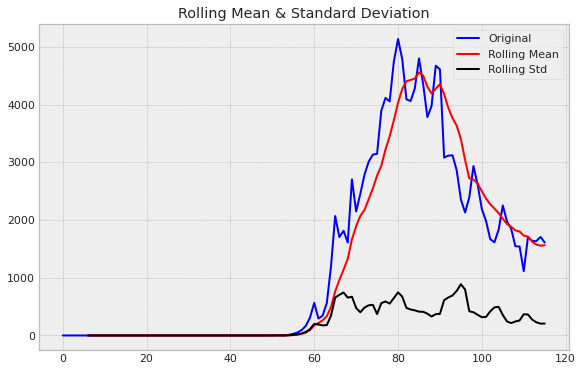

ADF Statistic: -1.9369547215587843
p-value: 0.31488103841793097
Critical Values:
	1%: -3.4936021509366793
	5%: -2.8892174239808703
	10%: -2.58153320754717


In [34]:
is_stationary(df_turkey_daily.Confirmed)

We need to **transform the data to stationary** before using our model. There are several methods for this. We will use **logarithmic** transformation from these. After taking the logarithm of the data, we also take the logarithms of rolling mean. Then we subtract this from the rolling log. mean. These stages enable us to discard the trend in the data.

In [0]:
turkey_daily_log = np.log(df_turkey_daily.loc[:, ['Confirmed']])
turkey_daily_log = turkey_daily_log.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

log_rolling_mean = turkey_daily_log.rolling(window=7).mean()
df_log_minus_mean = turkey_daily_log - log_rolling_mean
df_log_minus_mean = df_log_minus_mean.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

As seen below, according to ADF test, our statistical values are in the form of stationary time series data. Test statistics value is less than critical value and p-value is less than 0.05. We **obtained more stationary** data than the original data.

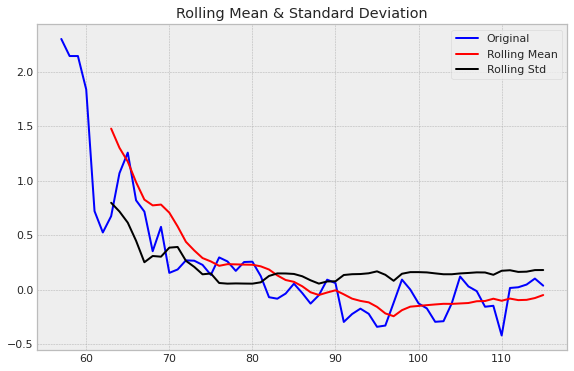

ADF Statistic: -4.48639557941454
p-value: 0.0002080748279385196
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


In [36]:
is_stationary(df_log_minus_mean.Confirmed)

We shift the data once and get the difference again. As a result, it becomes more stationary.

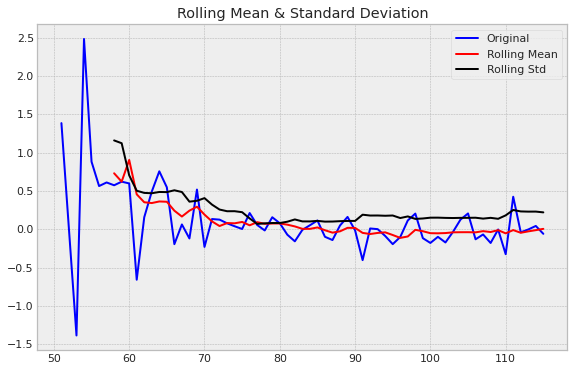

ADF Statistic: -4.5065272990105045
p-value: 0.00019136812969821089
Critical Values:
	1%: -3.560242358792829
	5%: -2.9178502070837
	10%: -2.5967964150943397


In [37]:
turkey_daily_log_shift = turkey_daily_log - turkey_daily_log.shift()
turkey_daily_log_shift = turkey_daily_log_shift.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
is_stationary(turkey_daily_log_shift.Confirmed)

# ARIMA

In order to make the data stationary, it seems enough to take the d parameter as 1. Since we will estimate each value with the previous 2 values and calculate the error accordingly, we select p and q values 2.

In [0]:
date_idx = [116 + x for x in range(0,40)]
dates = pd.date_range(start='2020-01-22', end='2020-06-25')

def calculate_arima_by_country(_df, country_name, split_perc=0.85):
    param = (1,1,2)

    if country_name == 'Global':
        df_ts = daily_df
        param = (2,1,2)
    else:
        df_ts = get_df_by_country(_df, country_name, daily=True)

    country_train = df_ts[:int(len(df_ts)*split_perc)].loc[:, 'Confirmed'].values
    country_train = pd.DataFrame(data=country_train[:], index=dates[:int(len(df_ts)*split_perc)], columns=['Confirmed'])
    country_test = df_ts[int(len(df_ts)*split_perc):].loc[:, 'Confirmed'].values

    model = ARIMA(country_train, order=param)
    result = model.fit()
    fig, ax = plt.subplots(figsize=(14, 6))
    ax = country_train.loc['2020-03-01':].plot(ax=ax)
    fig = result.plot_predict(start=int(len(country_train)/1.01), end=int(len(country_train)* 1.5), 
                              ax=ax, plot_insample=False)
    predictions = result.forecast(steps=len(country_test))[0]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=21))
    plt.legend()
    plt.xlabel("Dates")
    plt.ylabel("Cases")
    plt.title("ARIMA: COVID-19 Forecasting for " + country_name)
    plt.gcf().autofmt_xdate()
    plt.show()

    # mean absolute percentage error (MAPE), is a measure of
    # prediction accuracy of a forecasting method in statistics
    print('Mean absolute percentage error: %f'%mean_absolute_percentage_error(country_test, predictions))
    return predictions

According to the estimates, the number of daily world-wide cases will remain stable for a long time in high numbers.

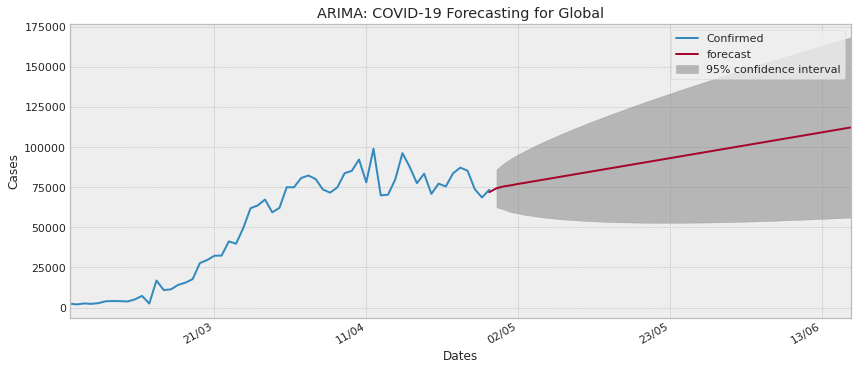

Mean absolute percentage error: 6.730487


In [39]:
forecast_values = calculate_arima_by_country(df, 'Global', 0.85)

In Turkey, according to estimates made for the lower limit of the epidemic it is expected to end in **June**.

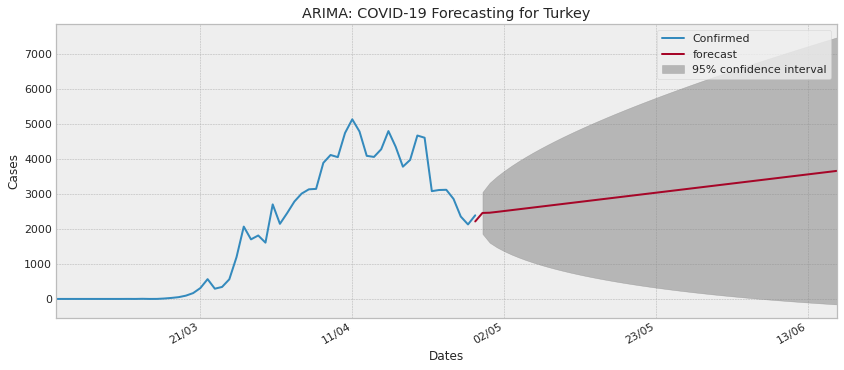

Mean absolute percentage error: 52.947683


In [40]:
forecast_values = calculate_arima_by_country(df, 'Turkey', 0.85)

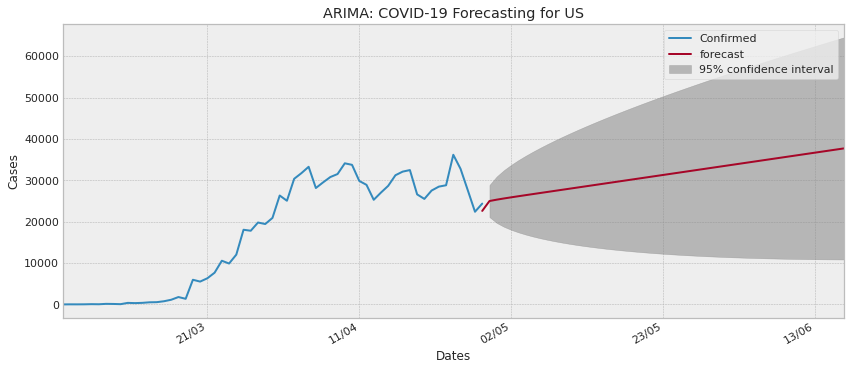

Mean absolute percentage error: 17.432782


In [41]:
forecast_values = calculate_arima_by_country(df, 'US', 0.85)

# Seasonal ARIMA

We apply the stabilization processes we do for the ARIMA model.

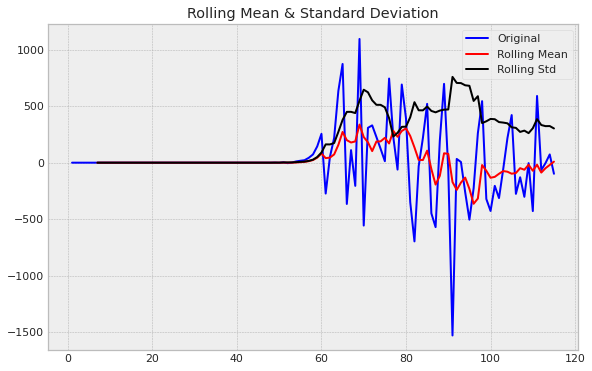

ADF Statistic: -3.403784098767173
p-value: 0.010830546374920228
Critical Values:
	1%: -3.4912451337340342
	5%: -2.8881954545454547
	10%: -2.5809876033057852


In [42]:
df_turkey_daily['first_diff'] = df_turkey_daily.Confirmed - df_turkey_daily.Confirmed.shift(1)
is_stationary(df_turkey_daily.first_diff.dropna(inplace=False))

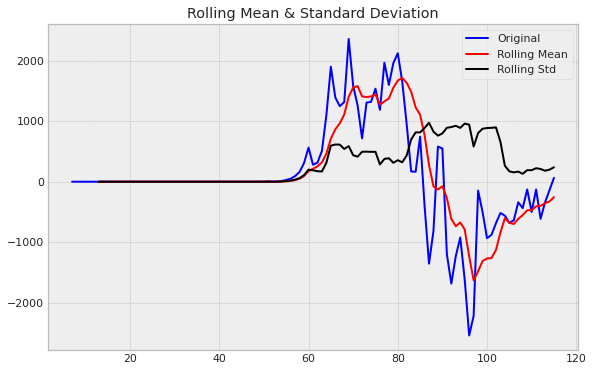

ADF Statistic: -3.430621514845586
p-value: 0.009958239993839706
Critical Values:
	1%: -3.5011373281819504
	5%: -2.8924800524857854
	10%: -2.5832749307479226


In [43]:
df_turkey_daily['seasonal_diff'] = df_turkey_daily.Confirmed - df_turkey_daily.Confirmed.shift(7)
is_stationary(df_turkey_daily.seasonal_diff.dropna(inplace=False))

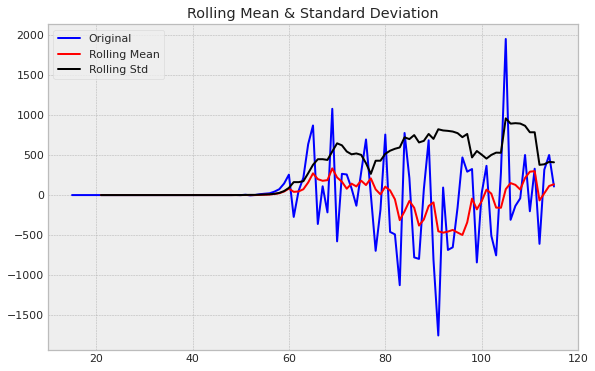

ADF Statistic: -2.9013729550135574
p-value: 0.04518857427257203
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872


In [44]:
df_turkey_daily['seasonal_first_diff'] = df_turkey_daily.first_diff - df_turkey_daily.first_diff.shift(14)
is_stationary(df_turkey_daily.seasonal_first_diff.dropna(inplace=False))

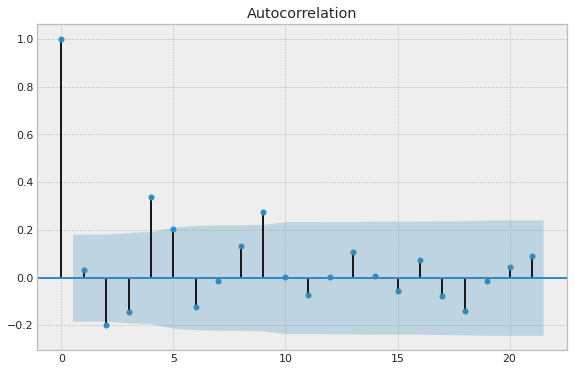

In [45]:
fig = sm.graphics.tsa.plot_acf(df_turkey_daily.Confirmed.diff().dropna())

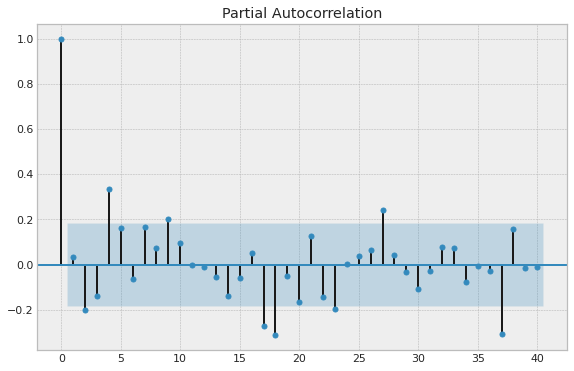

In [46]:
fig = sm.graphics.tsa.plot_pacf(df_turkey_daily.Confirmed.diff().dropna(), lags=40)

We chose to make an estimate compared to the previous 2 weeks since we received the data rounding average of 7 days.

In [47]:
mod = sm.tsa.statespace.SARIMAX(df_turkey_daily.Confirmed, trend='n', order=(14,0,7))
results = mod.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:              Confirmed   No. Observations:                  116
Model:              SARIMAX(14, 0, 7)   Log Likelihood                -810.790
Date:                Sat, 23 May 2020   AIC                           1665.580
Time:                        03:17:14   BIC                           1726.159
Sample:                             0   HQIC                          1690.172
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2728      1.729      0.158      0.875      -3.117       3.663
ar.L2         -0.0426      0.552     -0.077      0.938      -1.124       1.039
ar.L3         -0.2152      0.583     -0.369      0.7

We wanted to make a 40-day forecast. For this, we have added the datetime lines of the next 40 days to our data.

In [0]:
future = pd.DataFrame(index=date_idx, columns=df_turkey_daily.columns)

df_turkey_concat = pd.concat([df_turkey_daily, future])
df_turkey_concat['Date'] = dates
df_turkey_concat = df_turkey_concat.loc[:, ['Date', 'Country/Region', 'Confirmed' ]]

In [0]:
df_turkey_concat['forecast'] = results.predict(start = 90, end = 155)

According to the parameters we have chosen for SARIMAX, the outbreak is expected to end on **June 29**. This data matches the June value we obtained with ARIMA. The error rate was close to the error rate of the ARIMA model.

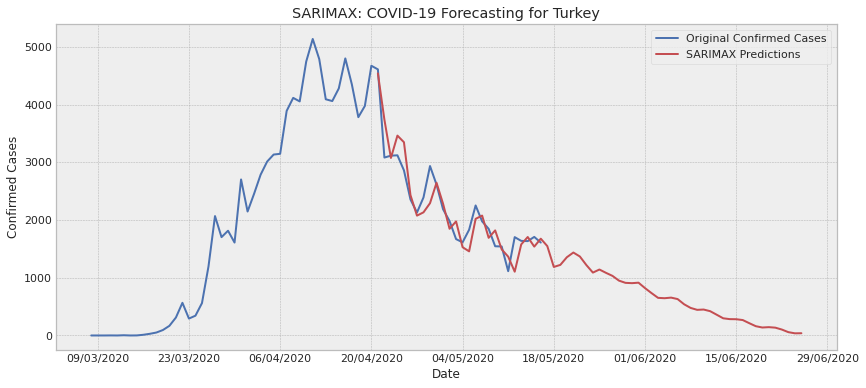

Mean absolute percentage error: 10.813673


<Figure size 684x432 with 0 Axes>

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))
df_turkey_concat = df_turkey_concat.iloc[-110:]

ax.plot(df_turkey_concat['Date'].values, df_turkey_concat['Confirmed'], label='Original Confirmed Cases', color='b')
ax.plot(df_turkey_concat['Date'].values, df_turkey_concat['forecast'], label='SARIMAX Predictions', color='r')

ax.set(xlabel="Date",
       ylabel="Confirmed Cases",
       title="SARIMAX: COVID-19 Forecasting for Turkey")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

print('Mean absolute percentage error: %f'%mean_absolute_percentage_error(df_turkey_concat.iloc[50:70].Confirmed, df_turkey_concat.iloc[50:70].forecast))

# DENEME

useful verisetindeki karantina (to_categorical), government response, ülke nüfusu, ortalama yaş gibi etkenleri asıl veriye katarak herhangi bir ülke özelinde linear regression modeli oluştur.

cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
details['total_cases']=details['Confirmed'] + details['Deaths'] + details['Recovered']
# Active Case = confirmed - deaths - recovered
details['Active'] = details['Confirmed'] - details['Deaths'] - details['Recovered']
# replacing Mainland china with just China
details['Country/Region'] = details['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
details[['Province/State']] = details[['Province/State']].fillna('')
details[cases] = details[cases].fillna(0)

# fixing datatypes
details['Recovered'] = details['Recovered'].astype(int)

details.sample(6)